# Setup drive and folder

Per accedere alla cartella --> Tasto destro sulla cartella condivisa < Final Project > e aggiungere scorciatoia al MyDrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/SL_Astro

/content/drive/MyDrive/SL_Astro


In [3]:
!pip install astropy
!pip install matplotlib
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#%cd /content/drive/MyDrive/SL_Astro

# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import pickle

# manage image
from PIL import Image
from skimage.util import view_as_blocks
from patchify import patchify

# manage Fits format
from astropy.io import fits
from astropy.visualization import ZScaleInterval, MinMaxInterval, PowerDistStretch, SinhStretch, LogStretch

# U-Net model
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import concatenate, Conv2D, Cropping2D, Input, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
import keras
from keras import backend as K


# U-Net implementation

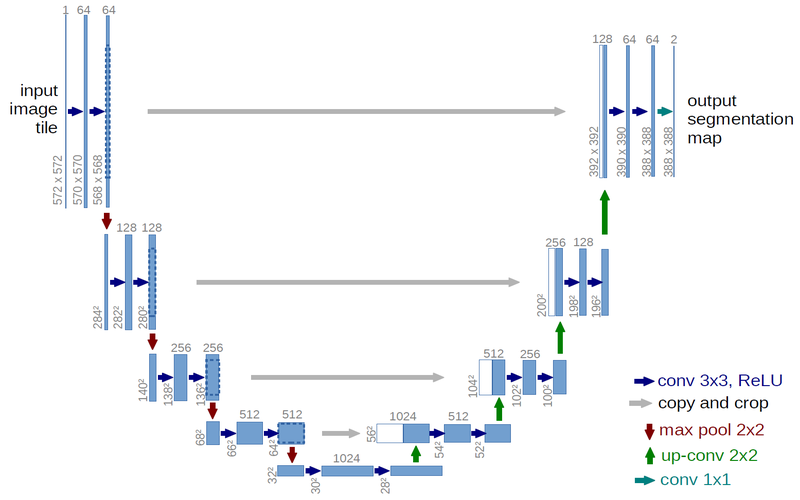

In [ ]:
img = Image.open("code/U-Net/u-net-architecture.png")
img = img.resize((800,500), Image.ANTIALIAS)
img

The network architecture is illustrated above. It consists of a contracting path (left side) and an expansive path (right side).

The **contracting path** follows the typical architecture of a convolutional network.It consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels.


Every step in the **expansive path** consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each fol-
lowed by a ReLU. The cropping is necessary due to the loss of border pixels in
every convolution. At the final layer a 1x1 convolution is used to map each 64-
component feature vector to the desired number of classes. In total the network
has 23 convolutional layers.

For a network with our architecture (alternating convolution and ReLU layers) this can be achieved by drawing the **initial weights** from a Gaussian distribution with a standard
deviation of $\sqrt{2/N}$, where N denotes the number of incoming nodes of one neuron

In [8]:
from keras import backend as K
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [5]:
K.clear_session()

def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

  inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

  # First conv pool
  c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)   
  c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D()(c1)   # default è (2,2)
  
  # Second conv pool
  c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D()(c2)

  # Third conv pool
  c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D()(c3)

  # Fourth conv pool
  c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D()(c4)

  # Fifth conv
  c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  # First up-conv
  u1 = UpSampling2D()(c5)    
  u1 = Conv2D(512, 2, padding='same')(u1)  #up-conv 2x2
  m1 = concatenate([c4, u1])
  cm1 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(m1)
  cm1 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(cm1)

  # Second up-conv
  u2 = UpSampling2D()(cm1)
  u2 = Conv2D(256, 2, padding='same')(u2)
  m2 = concatenate([c3, u2])
  cm2 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(m2)
  cm2 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(cm2)

  # Third up-conv
  u3 = UpSampling2D()(cm2)
  u3 = Conv2D(128, 2, padding='same')(u3)
  m3 = concatenate([c2, u3])
  cm3 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(m3)
  cm3 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(cm3)

  # Fourth up-conv
  u4 = UpSampling2D()(cm3)
  u4 = Conv2D(64, 2, padding='same')(u4)
  m4 = concatenate([c1, u4])
  cm4 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(m4)
  cm4 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(cm4)

  # Output 1x1
  predictions = Conv2D(1, 1, activation='sigmoid')(cm4)

  model = Model(inputs, predictions, name='Unet')
  model.compile(optimizer="Adam", 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.MeanIoU(num_classes=2),
                         tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.3),
                         tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5),
                         tf.keras.metrics.Recall(thresholds = 0.5),
                         dice_coef,
                         'accuracy'])
  print(model.summary())

  return model

In [6]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1

In [9]:
model = unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.save_weights('model_simple.h5')

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_23[0][0]']              
                                )                                                              

# Inspect the data

In [ ]:
# load the image
img_or = fits.getdata("MC_vis/img.fits")
img  = fits.getdata("MC_vis/img.fits")
img3 = fits.getdata("MC_vis/img_3.fits")

mask = fits.getdata("MC_vis/true.fits")
rms  = fits.getdata("MC_vis/rms.fits")

lets see only a single view

In [ ]:
norm = MinMaxInterval()

In [ ]:
img = img[500:1000, 500:1000]
img3 = img3[500:1000, 500:1000]
img_or = img_or[500:1000, 500:1000]
mask = mask[500:1000, 500:1000]
rms = rms[500:1000, 500:1000]

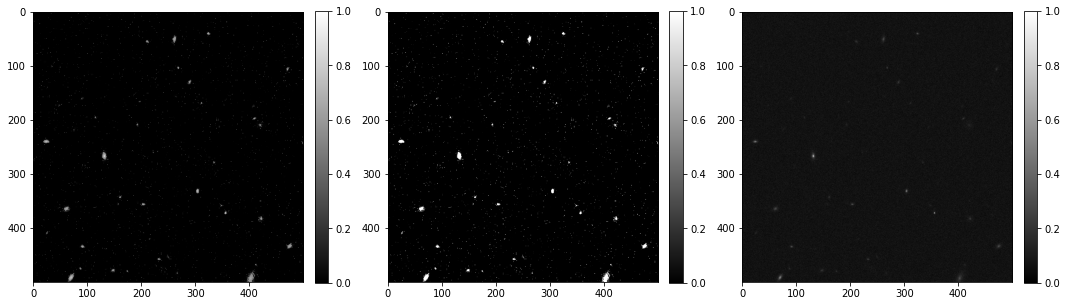

In [ ]:
# visualize figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
im1  = ax1.imshow(norm(norm(img3)+norm(rms)),  cmap='gray')
im2  = ax2.imshow(norm(img3),  cmap='gray')
im3  = ax3.imshow(norm(img_or),  cmap='gray')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04);

Look at the images

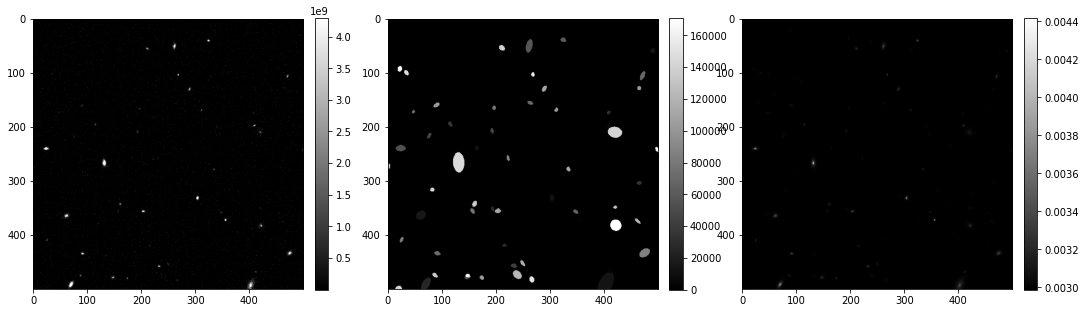

In [ ]:
# visualize figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
im1  = ax1.imshow(img,  cmap='gray')
im2  = ax2.imshow(mask,  cmap='gray')
im3  = ax3.imshow(rms,  cmap='gray')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04);

Transformation

In [ ]:
norm = MinMaxInterval()
logstre = LogStretch(500)

Inspect the streatch of the rms

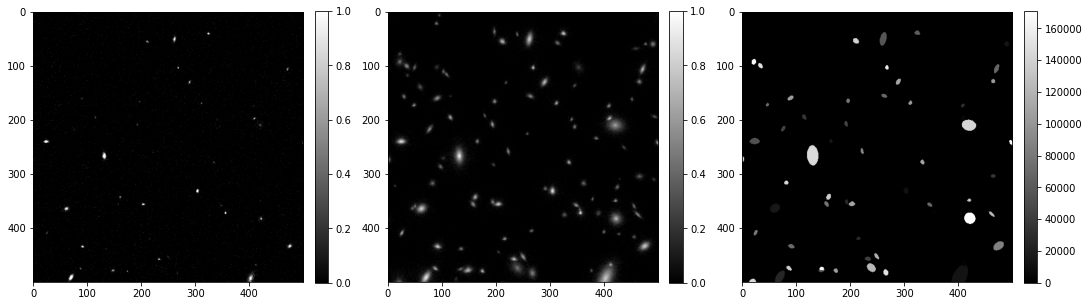

In [ ]:
# visualize figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
im1  = ax1.imshow(norm(img),  cmap='gray')
im2  = ax2.imshow(logstre(norm(rms)),  cmap='gray')
im3  = ax3.imshow(mask,  cmap='gray')

fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04);

In [ ]:
# try with IMG1
rms_enhance = logstre(norm(rms))
A = norm(img) + rms_enhance

# try with IMG3
rms_enhance = logstre(norm(rms))
B = norm(img3) + rms_enhance

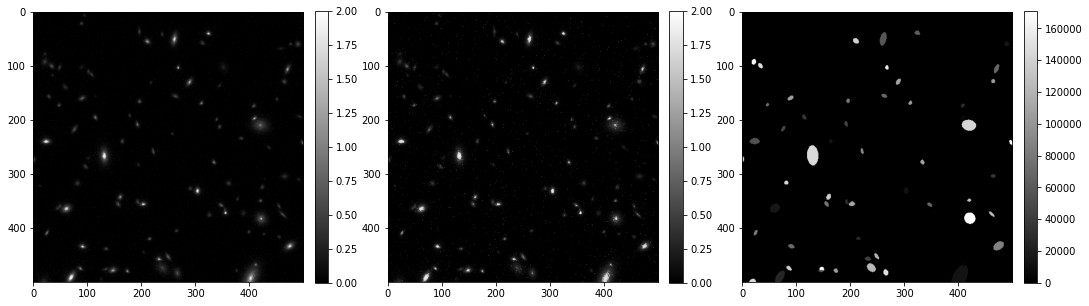

In [ ]:
# visualize figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
im1  = ax1.imshow(A,  cmap='gray')
im2  = ax2.imshow(B,  cmap='gray')
im3  = ax3.imshow(mask,  cmap='gray')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04);

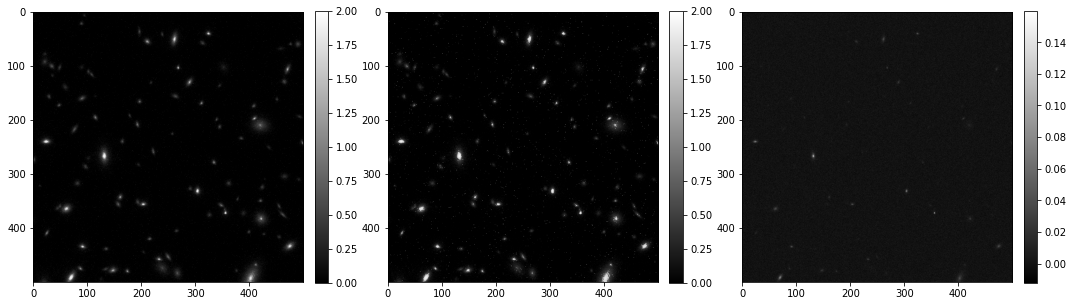

In [ ]:
# visualize figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
im1  = ax1.imshow(A,  cmap='gray')
im2  = ax2.imshow(B,  cmap='gray')
im3  = ax3.imshow(img_or,  cmap='gray')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04);

# Prepare the dataset 

Define the size of the patches for the training 

In [ ]:
norm = MinMaxInterval()
logstre = LogStretch(500)

In [ ]:
def generation_dataset(size, output_folder = ''): 
  
  # load the image
  img  = fits.getdata('./MC_vis/img_3.fits')
  mask = fits.getdata("./MC_vis/true.fits")
  rms  = fits.getdata("./MC_vis/rms.fits")

  # create the patch
  cc = 45
  img_patches  = patchify(img[size:(size*cc), size:(size*cc)], (size, size), step = size)
  mask_patches = patchify(mask[size:(size*cc), size:(size*cc)],(size, size), step = size)
  rms_patches  = patchify(rms[size:(size*cc), size:(size*cc)], (size, size), step = size)

  dim1, dim2, _, _ = img_patches.shape

  os.mkdir(output_folder)
  os.mkdir(output_folder+'/img')
  os.mkdir(output_folder+'/mask')
  os.mkdir(output_folder+'/rms')

  count = 0
  print("Salvando i file fits...")
  for i in tqdm(range(dim1)):
    for j in range(dim2):
      #hdu = fits.PrimaryHDU(norm(img_patches[i][j]))
      #hdu.writeto(output_folder + '/img/'+ str(count).zfill(6) +'.fits')
      # 
      imgToSave = norm(img_patches[i][j]) + norm(rms_patches[i][j])
      hdu = fits.PrimaryHDU(norm(imgToSave))
      hdu.writeto(output_folder + '/img/'+ str(count).zfill(6) +'.fits')
      # invariato
      hdu = fits.PrimaryHDU(norm(mask_patches[i][j]))
      hdu.writeto(output_folder + '/mask/'+ str(count).zfill(6) +'.fits')
      hdu = fits.PrimaryHDU(rms_patches[i][j])
      hdu.writeto(output_folder + '/rms/'+ str(count).zfill(6) +'.fits')
      count += 1

  return 

In [ ]:
%cd /content/drive/MyDrive/SL_Astro

/content/drive/MyDrive/SL_Astro


In [ ]:
size = 256
generation_dataset(size, output_folder = 'astrodataset4')

Salvando i file fits...


100%|██████████| 44/44 [02:00<00:00,  2.73s/it]


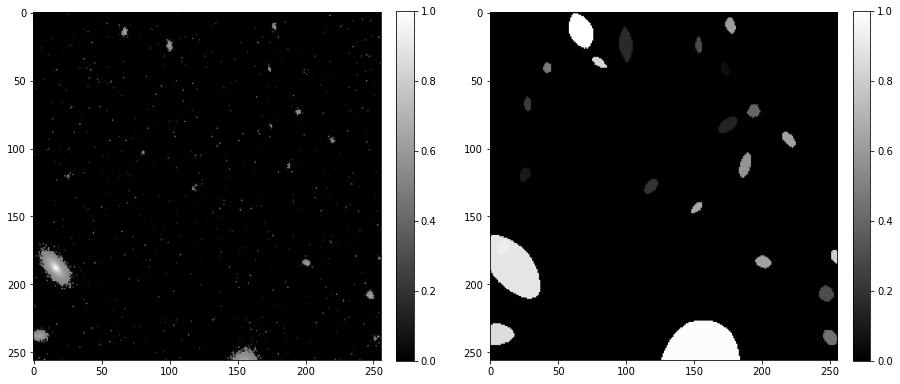

In [ ]:
#Sanity check, view few mages
lst = os.listdir("./astrodataset4/img") # your directory path
rnd  = random.randint(0, len(lst)-1)

img_test = fits.getdata('./astrodataset4/img/'+ str(rnd).zfill(6) +'.fits')
mask_test = fits.getdata('./astrodataset4/mask/'+ str(rnd).zfill(6) +'.fits')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
im1  = ax1.imshow(img_test,  cmap='gray')
im2  = ax2.imshow(mask_test,  cmap='gray')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04);

Load the dataset

In [ ]:
def DataLoader(folder, subfolder = 'img'):
  path = os.path.join(folder, subfolder)
  imgs = []
  print('Loading the images...')
  for img in tqdm(os.listdir(path)):
    imgs.append(fits.getdata(os.path.join(path, img)))
  return imgs

In [ ]:
folder = 'astrodataset3'

imgs = DataLoader(folder, 'img')

image_dataset = np.expand_dims(np.array(imgs),3)
print(image_dataset.shape)


with open('image_dataset3.pickle', 'wb') as handle:
    pickle.dump(image_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading the images...


100%|██████████| 1936/1936 [00:33<00:00, 57.93it/s] 


(1936, 256, 256, 1)


Reshape the data as the input for U-Net:


In [ ]:
masks = DataLoader(folder, 'mask')

mask_dataset = np.expand_dims(np.array(masks),3)
print(mask_dataset.shape)

with open('mask_dataset3.pickle', 'wb') as handle:
    pickle.dump(mask_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading the images...


100%|██████████| 1936/1936 [00:32<00:00, 59.09it/s] 


(1936, 256, 256, 1)


# Training of the model

In [ ]:
%cd /content/drive/MyDrive/SL_Astro

/content/drive/MyDrive/SL_Astro


In [ ]:
with open('image_dataset4.pickle', 'rb') as handle:
    image_dataset = pickle.load(handle)

In [ ]:
with open('mask_dataset4.pickle', 'rb') as handle:
    mask_dataset = pickle.load(handle)

Divide dataset in train, test 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.3, random_state = 1234)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1234)

print("Train shape: ", X_train.shape)
print("Validation shape: ", X_val.shape)
print("Test shape: ", X_test.shape)

Train shape:  (1750, 256, 256, 1)
Validation shape:  (375, 256, 256, 1)
Test shape:  (375, 256, 256, 1)


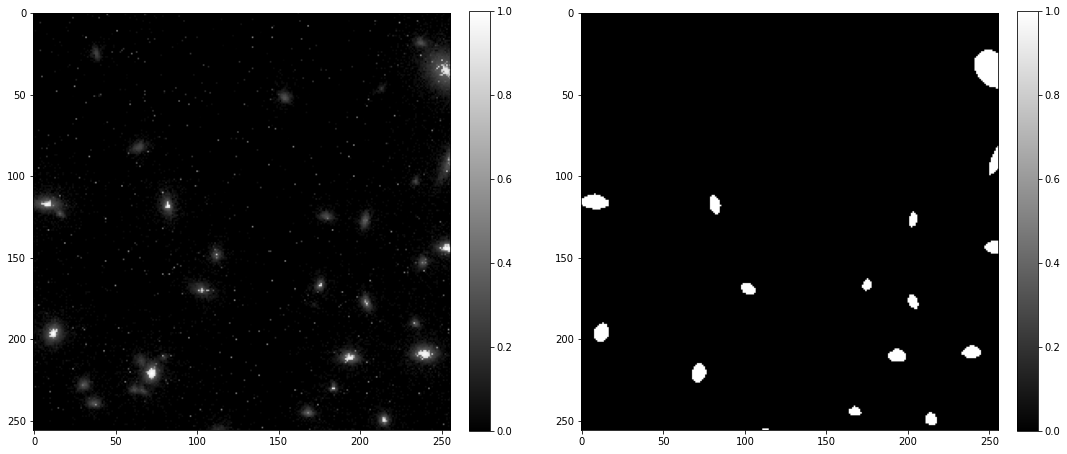

In [ ]:
# visualize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
im1  = ax1.imshow(X_train.reshape(-1, 256, 256)[1],  cmap='gray')
im2  = ax2.imshow(y_train.reshape(-1, 256, 256)[1],  cmap='gray')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04);

Train the model

In [ ]:
callbacks = EarlyStopping(patience = 5, 
                          monitor='val_binary_io_u_1',
                          restore_best_weights=True, 
                          mode='max')

model.load_weights('model_simple.h5')
history = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=30, 
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), 
                    shuffle=False)

model.save('./modello4.hdf5')

Epoch 1/30
219/219 [==============================] - 174s 701ms/step - loss: 0.1760 - mean_io_u: 0.4753 - binary_io_u: 0.3809 - binary_io_u_1: 0.4428 - recall: 0.5673 - dice_coef: 0.5274 - accuracy: 0.9638 - val_loss: 0.0823 - val_mean_io_u: 0.4748 - val_binary_io_u: 0.5633 - val_binary_io_u_1: 0.5356 - val_recall: 0.5877 - val_dice_coef: 0.4846 - val_accuracy: 0.9744
Epoch 2/30
219/219 [==============================] - 142s 647ms/step - loss: 0.0687 - mean_io_u: 0.4757 - binary_io_u: 0.5686 - binary_io_u_1: 0.5709 - recall: 0.6588 - dice_coef: 0.6339 - accuracy: 0.9749 - val_loss: 0.0602 - val_mean_io_u: 0.4906 - val_binary_io_u: 0.6579 - val_binary_io_u_1: 0.5962 - val_recall: 0.6337 - val_dice_coef: 0.5938 - val_accuracy: 0.9784
Epoch 3/30
219/219 [==============================] - 141s 645ms/step - loss: 0.0558 - mean_io_u: 0.4792 - binary_io_u: 0.6275 - binary_io_u_1: 0.6230 - recall: 0.7075 - dice_coef: 0.6900 - accuracy: 0.9783 - val_loss: 0.0567 - val_mean_io_u: 0.4748 - val_

# Evaluate the model and predictions

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=8, return_dict=True)
print("test loss, test acc:", results)

Evaluate on test data
47/47 [==============================] - 10s 204ms/step - loss: 0.0393 - mean_io_u: 0.4994 - binary_io_u: 0.7116 - binary_io_u_1: 0.7076 - recall: 0.7751 - dice_coef: 0.7493 - accuracy: 0.9838
test loss, test acc: {'loss': 0.03931943327188492, 'mean_io_u': 0.49937382340431213, 'binary_io_u': 0.7116168737411499, 'binary_io_u_1': 0.7075988054275513, 'recall': 0.7750893235206604, 'dice_coef': 0.7492967844009399, 'accuracy': 0.9837540984153748}


In [ ]:
with open('metrics_TEST4.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
with open('history4.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions")
predictions = model.predict(X_test).reshape(-1, IMG_HEIGHT, IMG_HEIGHT)
print("predictions shape:", predictions.shape)

Generate predictions
predictions shape: (375, 256, 256)


In [ ]:
#rnd1  = random.randint(0, len(X_test)-1)
#rnd2  = random.randint(0, len(X_test)-1)

rnd1 = 262
#print("Images numbers:", (rnd1, rnd2))

modello 4

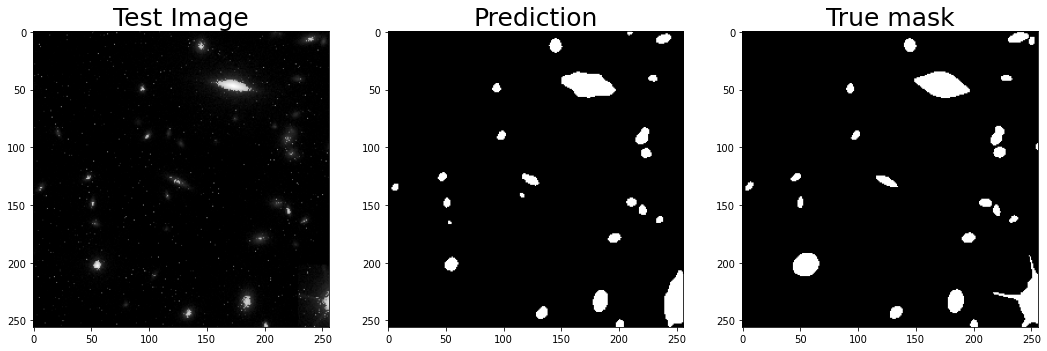

In [ ]:
fontdict_ = {'fontsize': 25,
             'fontweight':'light'}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,10))
ax1.imshow(X_test.reshape(-1, IMG_HEIGHT, IMG_HEIGHT)[rnd1], cmap  = 'gray')
ax1.set_title('Test Image', fontdict = fontdict_)
ax2.imshow(predictions[rnd1] > 0.5, cmap = 'gray')
ax2.set_title('Prediction', fontdict = fontdict_)
ax3.imshow(y_test.reshape(-1, IMG_HEIGHT, IMG_HEIGHT)[rnd1], cmap  = 'gray')
ax3.set_title('True mask', fontdict = fontdict_)
plt.savefig('prediction4.pdf')
plt.show()

modello 3

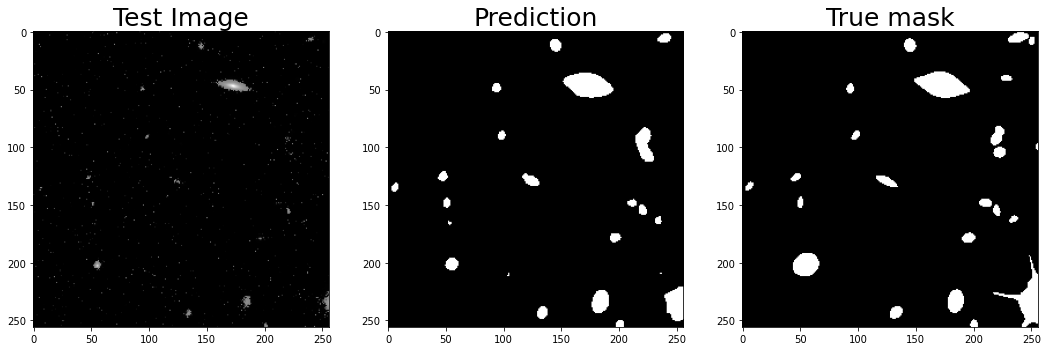

In [ ]:
fontdict_ = {'fontsize': 25,
             'fontweight':'light'}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,10))
ax1.imshow(X_test.reshape(-1, IMG_HEIGHT, IMG_HEIGHT)[rnd1], cmap  = 'gray')
ax1.set_title('Test Image', fontdict = fontdict_)
ax2.imshow(predictions[rnd1] > 0.5, cmap = 'gray')
ax2.set_title('Prediction', fontdict = fontdict_)
ax3.imshow(y_test.reshape(-1, IMG_HEIGHT, IMG_HEIGHT)[rnd1], cmap  = 'gray')
ax3.set_title('True mask', fontdict = fontdict_)
plt.savefig('prediction3.pdf')
plt.show()

modello 2

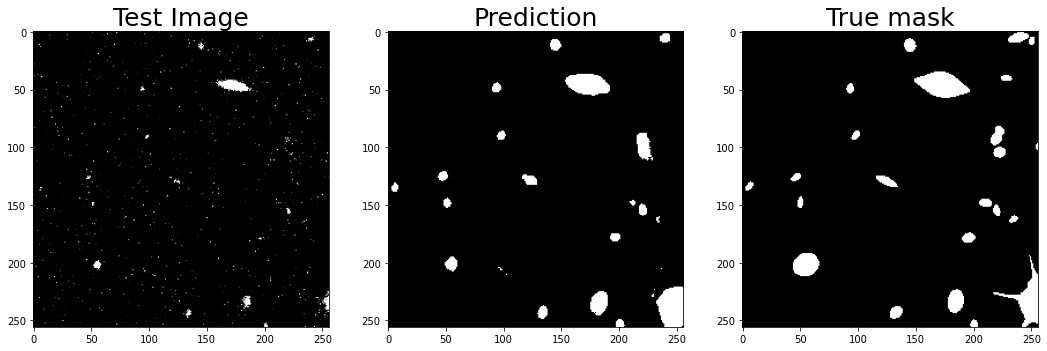

In [ ]:
fontdict_ = {'fontsize': 25,
             'fontweight':'light'}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,10))
ax1.imshow(X_test.reshape(-1, IMG_HEIGHT, IMG_HEIGHT)[rnd1], cmap  = 'gray')
ax1.set_title('Test Image', fontdict = fontdict_)
ax2.imshow(predictions[rnd1] > 0.5, cmap = 'gray')
ax2.set_title('Prediction', fontdict = fontdict_)
ax3.imshow(y_test.reshape(-1, IMG_HEIGHT, IMG_HEIGHT)[rnd1], cmap  = 'gray')
ax3.set_title('True mask', fontdict = fontdict_)
plt.savefig('prediction2.pdf')
plt.show()

modello 1

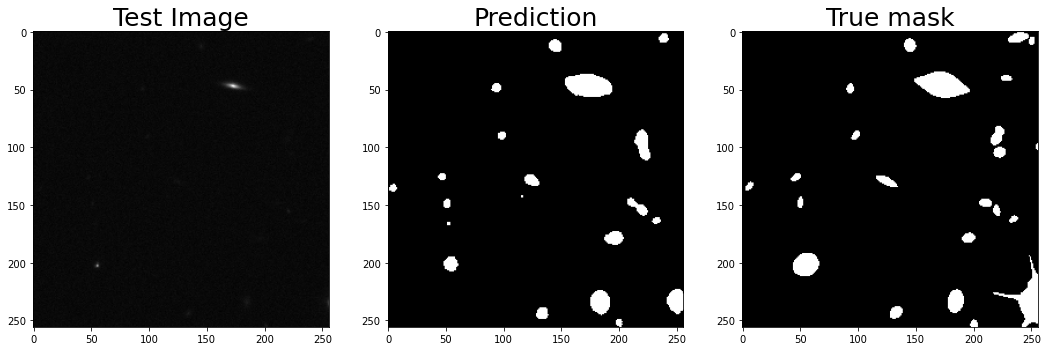

In [ ]:
fontdict_ = {'fontsize': 25,
             'fontweight':'light'}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,10))
ax1.imshow(X_test.reshape(-1, IMG_HEIGHT, IMG_HEIGHT)[rnd1], cmap  = 'gray')
ax1.set_title('Test Image', fontdict = fontdict_)
ax2.imshow(predictions[rnd1] > 0.5, cmap = 'gray')
ax2.set_title('Prediction', fontdict = fontdict_)
ax3.imshow(y_test.reshape(-1, IMG_HEIGHT, IMG_HEIGHT)[rnd1], cmap  = 'gray')
ax3.set_title('True mask', fontdict = fontdict_)
plt.savefig('prediction1.pdf')
plt.show()